In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
import os
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import cross_val_predict
import math
from quantile_forest import RandomForestQuantileRegressor
import shap
from benchmark_pipeline import read_features
# df = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/data/002_data_whole.csv',low_memory=False)
output_folder = '/mnt/primus/xuemeng_tmp_harbour/soc/results'

# a = find_files('/mnt/primus/xuemeng_tmp_harbour/soc/results/', 'model_rf.*.ccc.joblib')
# a = [str(i) for i in a]

prop = 'oc'
file_rf =  f'/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/model_rf.{prop}_log1p.ccc.joblib'

results = []
cv = GroupKFold(n_splits=5)  
spatial_cv_column = 'tile_id'

test = pd.read_csv(f'{output_folder}/{prop}/benchmark_test.pnts_{prop}.csv',low_memory=False)
train = pd.read_csv(f'{output_folder}/{prop}/benchmark_train.pnts_{prop}.csv',low_memory=False)

covs = read_features(f'/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/feature_optimal.txt')
    
train = train.dropna(subset=covs,how='any')
test = test.dropna(subset=covs,how='any')


# params = rf.get_params()
# # params['n_jobs'] = 90
# qrf = RandomForestQuantileRegressor(**params)

# get SHAP values
rf = joblib.load(file_rf)
rf.n_jobs = 90
rf.fit(train[covs],train[prop])
y_pred_test = rf.predict(test[covs]) 

### SHAP on RF predictions

In [2]:
# SHAP values generation
ttprint('start SHAP calculating')
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test[covs])
ttprint('finish SHAP calculating')

with open(f'/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/shap.values_v0703.csv', 'wb') as f:
    pickle.dump(shap_values, f)

[11:22:28] start SHAP calculating
[12:38:59] finish SHAP calculating


In [6]:
# get feature improtance, and store them in a dataframe in a sorted way
feature_importances = rf.feature_importances_
features = train[covs].columns
feature_importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Select top 10 important features
top_features = feature_importance_df.head(10)['feature'].tolist()


In [7]:
feature_importance_df.head(10)

feature  importance
10  pet.penman.max_chelsa_m_1km_s_19810101_2010123...    0.188920
0   ndti_glad.landast.ard2.seasconv.m.yearly_p25_3...    0.064174
45  rsds.mean_chelsa_m_1km_s_19810101_20101231_eu_...    0.063859
1   bioclim.var_chelsa.bio10_m_1km_s_19810101_2010...    0.050950
39  rsds.min_chelsa_m_1km_s_19810101_20101231_eu_e...    0.039294
11                                lithology_EGDI_peat    0.038371
8   ndti_glad.landast.ard2.seasconv.m.yearly_p50_3...    0.029613
4   vpd.max_chelsa_m_1km_s_19810101_20101231_eu_ep...    0.025973
5   ndvi_glad.landsat.ard2.seasconv.longterm_p25_3...    0.021572
22  twi.bareearth_ensemble_m_60m_s_20000101_202212...    0.020645

In [5]:
feature_importance_df.to_csv('/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/feature_importance.csv',index=False)

### visualization

In [19]:
import statsmodels.api as sm
def plot_pdp_1way(feat_l,y_pred,feat_name):
    # Scatter plot of the actual data points
    plt.figure(figsize=(7, 5))
    plt.scatter(feat_l, y_pred, color='lightblue', alpha=0.6, label='Data Points')

    # Generate a smoothed lowess line to act as the PDP
    lowess = sm.nonparametric.lowess
    z = lowess(y_pred, feat_l, frac=0.1)  # Adjust frac for more or less smoothing

    # Plotting the smoothed line
    plt.plot(z[:, 0], z[:, 1], color='red', linewidth=2, label='Smoothed PDP (Lowess Fit)')

    # Customizing the plot
    plt.title('Partial Dependence Plot')
    plt.xlabel(feat_name)
    plt.ylabel('SOC (g/kg)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [2]:
with open(f'/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/shap.values_v0703.csv', 'rb') as file:
    shap_values = pickle.load(file)
    

In [3]:
feature_importance_df = pd.read_csv('/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/feature_importance.csv',low_memory=False)
covs_interest = feature_importance_df.head(10)['feature'].tolist() # Select features of interest
ind_interest = [test[covs].columns.get_loc(feat) for feat in covs_interest]
selected_shap_values = shap_values[:, ind_interest]

In [4]:
covs_interest
# # SHAP summary plot
# # pet.penman.max - The highest monthly potential evaporation; calculated with the Penman-Monteith equation.
# # rsds.min - The lowest monthly surface downwelling shortwave flux in air
# # chelsa.bio10 - mean daily mean air temperatures of the warmest quarter
# # rsds.mean - Average monthly surface downwelling shortwave flux in air over 1 year
# # twi.bareearth - Topographic wetness index, used to quantify topographic control on hydrological processes. The index is a function of both the slope and the upstream contributing area per unit width orthogonal to the flow direction.
# # vpd.max - The highest monthly vapor pressure deficit, drying power of the air

['pet.penman.max_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
 'ndti_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
 'rsds.mean_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
 'bioclim.var_chelsa.bio10_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822',
 'rsds.min_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
 'lithology_EGDI_peat',
 'ndti_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
 'vpd.max_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
 'ndvi_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231127',
 'twi.bareearth_ensemble_m_60m_s_20000101_20221231_eu_epsg.3035_v20240501']

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


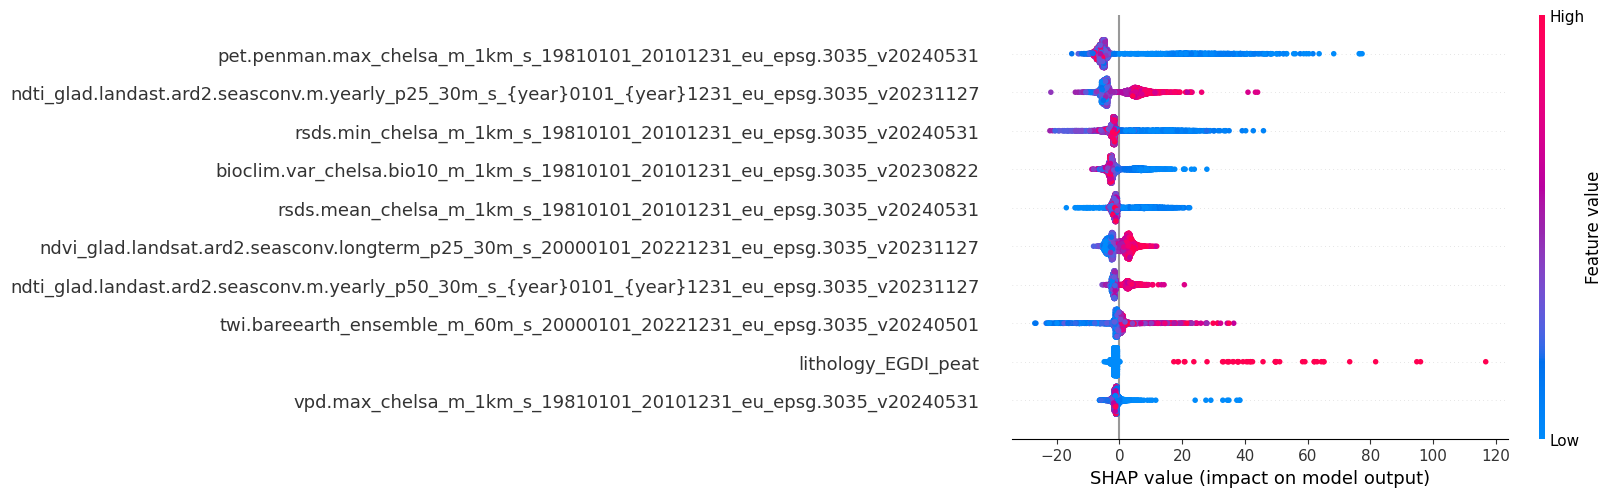

In [5]:
shap.summary_plot(shap_values[:, ind_interest], test[covs_interest])


In [21]:
for iind in ind_interest:
    feat_num = [covs.index(covs_interest[iind])] # select the featurs
    feat = covs_interest[iind]
    feat_name = feat.split('_')[0]+'_'+feat.split('_')[1]+'_'+feat.split('_')[5]+'_'+feat.split('_')[6]
    plot_pdp_1way(test[feat],y_pred_test,feat_name)

IndexError: list index out of range

In [22]:
ind_interest

[10, 0, 45, 1, 39, 11, 8, 4, 5, 22]

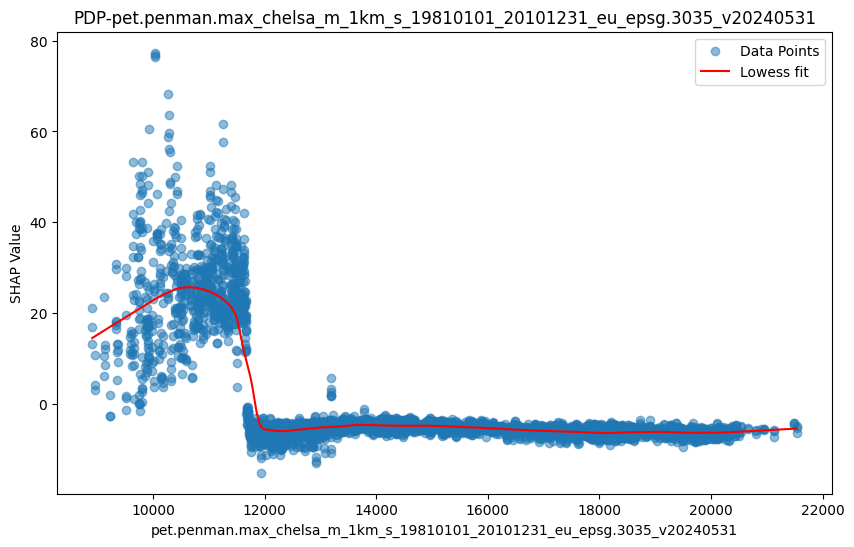

In [49]:
import statsmodels.api as sm

feature_name = covs_interest[0]  # Make sure this is correctly assigned
feature_values = test[feature_name].values  # Ensure this extracts a 1D array
shap_feat = shap_values[:, covs.index(feature_name)]  # Extract 1D SHAP values for the feature

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(feature_values, shap_feat, alpha=0.5, label='Data Points')  # Scatter plot of SHAP values

# Generate a smoothed lowess line
lowess = sm.nonparametric.lowess
z = lowess(shap_feat, feature_values, frac=0.1)  # Adjust frac for more or less smoothing

# Plotting the smoothed line
plt.plot(z[:, 0], z[:, 1], color='red', label='Lowess fit')

# Add labels and legend
plt.xlabel(feature_name)  # Feature name
plt.ylabel('SHAP Value')
plt.title(f'PDP-{feature_name}')
plt.legend()

plt.show()

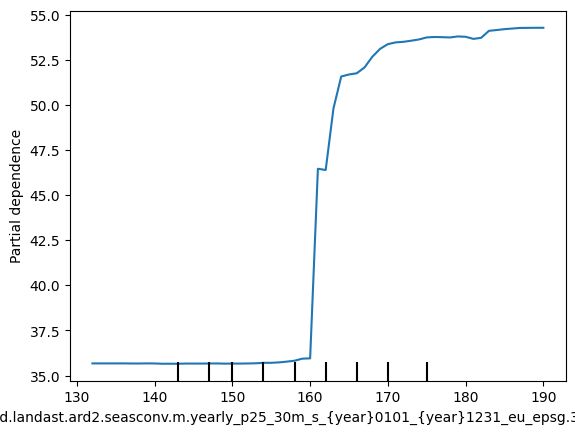

In [31]:
feat = [covs.index(covs_interest[1])] # select the featurs


# PDP from model
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(rf, test[covs], feat)
# higher NDTI means more crop residue cover, less exposed bare soil

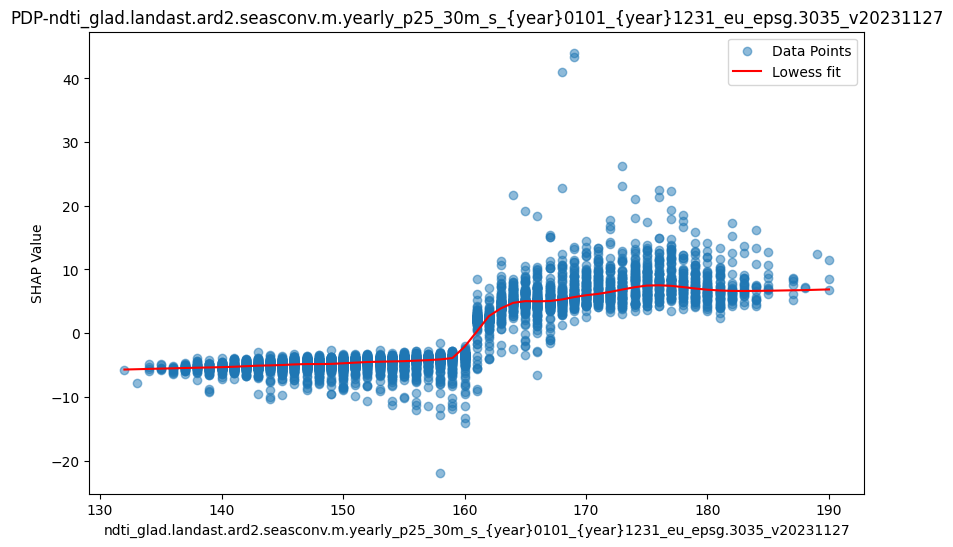

In [52]:
# PDP from SHAP
import statsmodels.api as sm

feature_name = covs_interest[1]  # Make sure this is correctly assigned
feature_values = test[feature_name].values  # Ensure this extracts a 1D array
shap_feat = shap_values[:, covs.index(feature_name)]  # Extract 1D SHAP values for the feature

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(feature_values, shap_feat, alpha=0.5, label='Data Points')  # Scatter plot of SHAP values

# Generate a smoothed lowess line
lowess = sm.nonparametric.lowess
z = lowess(shap_feat, feature_values, frac=0.1)  # Adjust frac for more or less smoothing

# Plotting the smoothed line
plt.plot(z[:, 0], z[:, 1], color='red', label='Lowess fit')

# Add labels and legend
plt.xlabel(feature_name)  # Feature name
plt.ylabel('SHAP Value')
plt.title(f'PDP-{feature_name}')
plt.legend()

plt.show()

In [54]:
covs_interest

['pet.penman.max_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
 'ndti_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
 'rsds.mean_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
 'bioclim.var_chelsa.bio10_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822',
 'rsds.min_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
 'lithology_EGDI_peat',
 'ndti_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
 'vpd.max_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
 'ndvi_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231127',
 'twi.bareearth_ensemble_m_60m_s_20000101_20221231_eu_epsg.3035_v20240501']

In [ ]:
# two-way PDP
feat = [('', '')]

fig, ax = plt.subplots(figsize=(8, 6))
plot_partial_dependence(rf, features=feat, X=test[covs], ax=ax, grid_resolution=20)

plt.suptitle(f'Partial Dependence of target on {feat[0][0]} and {feat[0][1]}')
plt.subplots_adjust(top=0.9)  # Adjust plot to not overlap with title
plt.show()

### quantile random forest - metrics
- cv
- individual test

In [58]:
quantiles = [0.05,0.95]
results = []
cv = GroupKFold(n_splits=5)  
spatial_cv_column = 'tile_id'

# get SHAP values
qrf = joblib.load('/mnt/primus/xuemeng_tmp_harbour/soc/results/production_model/propduction.quantile.model_rf.oc_log1p.ccc.weighted.joblib')
qrf.fit(train[covs], train[prop])
y_pred_test = qrf.predict(test[covs], quantiles=quantiles[0])
    
ttprint('start SHAP calculating for QRF')
explainer = shap.TreeExplainer(qrf)
shap_values = explainer.shap_values(test[covs])
ttprint('finish SHAP calculating for QRF')

with open(f'/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/shap.values_qrf.p05_v0703.csv', 'wb') as f:
    pickle.dump(shap_values, f)
    

[14:00:43] start SHAP calculating for QRF


X has feature names, but RandomForestQuantileRegressor was fitted without feature names


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'quantile_forest._quantile_forest.RandomForestQuantileRegressor'>

### explain the model with SHAP values

In [ ]:
# https://shap.readthedocs.io/en/latest/

In [4]:
import numpy as np
quantiles = [0.005, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
             0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.995]

qrf.fit(train[covs], train[prop])
y_pred_test = qrf.predict(test[covs], quantiles=quantiles)

/home/opengeohub/.local/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


In [5]:

qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_pred_test[:,ii], test[prop], quantiles[ii]))

pi = []
picp = []
piw = []
for ii in range(11):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_pred_test[:,ii], y_pred_test[:,jj], test[prop]))
    piw.append(np.mean(y_pred_test[:,jj]-y_pred_test[:,ii]))


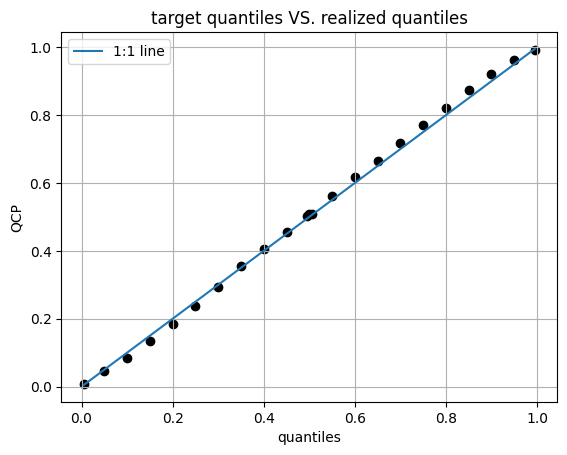

In [6]:
fig, ax = plt.subplots()
ax.plot(quantiles, quantiles, label='1:1 line')
ax.scatter(quantiles, qcp, color='black')
ax.set_xlabel('quantiles')
ax.set_ylabel('QCP')
ax.set_title('target quantiles VS. realized quantiles')
ax.grid(True)
plt.legend()
plt.show()

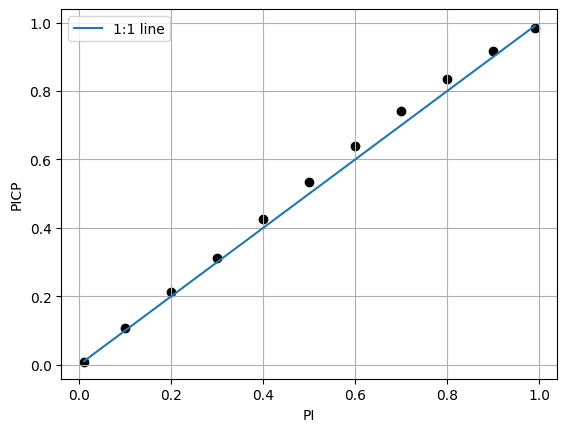

In [7]:
fig, ax = plt.subplots()
ax.plot(pi, pi, label='1:1 line')
ax.scatter(pi, picp, color='black')
ax.set_xlabel('PI')
ax.set_ylabel('PICP')
ax.grid(True)
plt.legend()
plt.show()

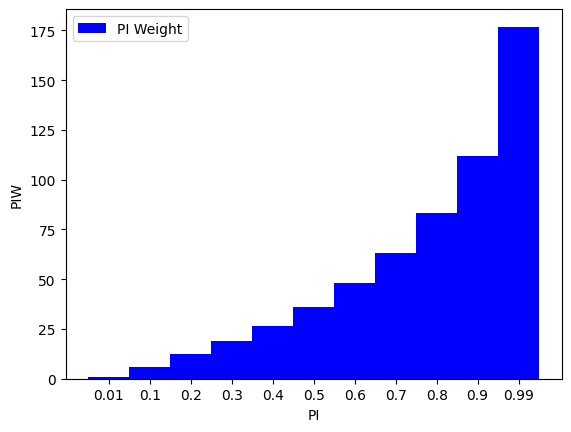

In [8]:
x_positions = list(range(len(piw), 0, -1))

fig, ax = plt.subplots()
ax.bar(x_positions, piw, width=1, color='blue', label='PI Weight')
ax.set_xticks(x_positions)  # Set x-ticks at the positions listed in `pi`
ax.set_xticklabels([f'{p}' for p in pi])
ax.set_xlabel('PI')
ax.set_ylabel('PIW')
# ax.grid(True)
plt.legend()
plt.show()

### validate on validation set time series

In [9]:
test['oc_quantile.95'] = y_pred_test[:,-2]
test['oc_quantile.05'] = y_pred_test[:,1]

In [11]:
data = test[test['hzn_dep'] == 10]
columns_of_interest = ['id', 'time', 'oc', 'oc_quantile.95', 'oc_quantile.05']
data = data[columns_of_interest]

data

id    time    oc  oc_quantile.95  oc_quantile.05
1     56922206  2009.0   6.5          28.420          6.4000
3     56882134  2009.0  14.8          45.725          8.3000
4     56722160  2009.0  15.6          30.640          8.2450
5     56302122  2009.0   7.9          25.230          5.2000
6     55682118  2009.0   4.7          22.675          5.2000
...        ...     ...   ...             ...             ...
4540  34923790  2018.0  28.9         102.945          9.5335
4541  34983770  2018.0  19.1         130.650          9.8850
4542  34443626  2018.0  34.6         148.928         23.8500
4543  35483702  2018.0  44.1         301.185         22.8750
4544  32543634  2018.0  47.9         254.030         24.0350

[4521 rows x 5 columns]

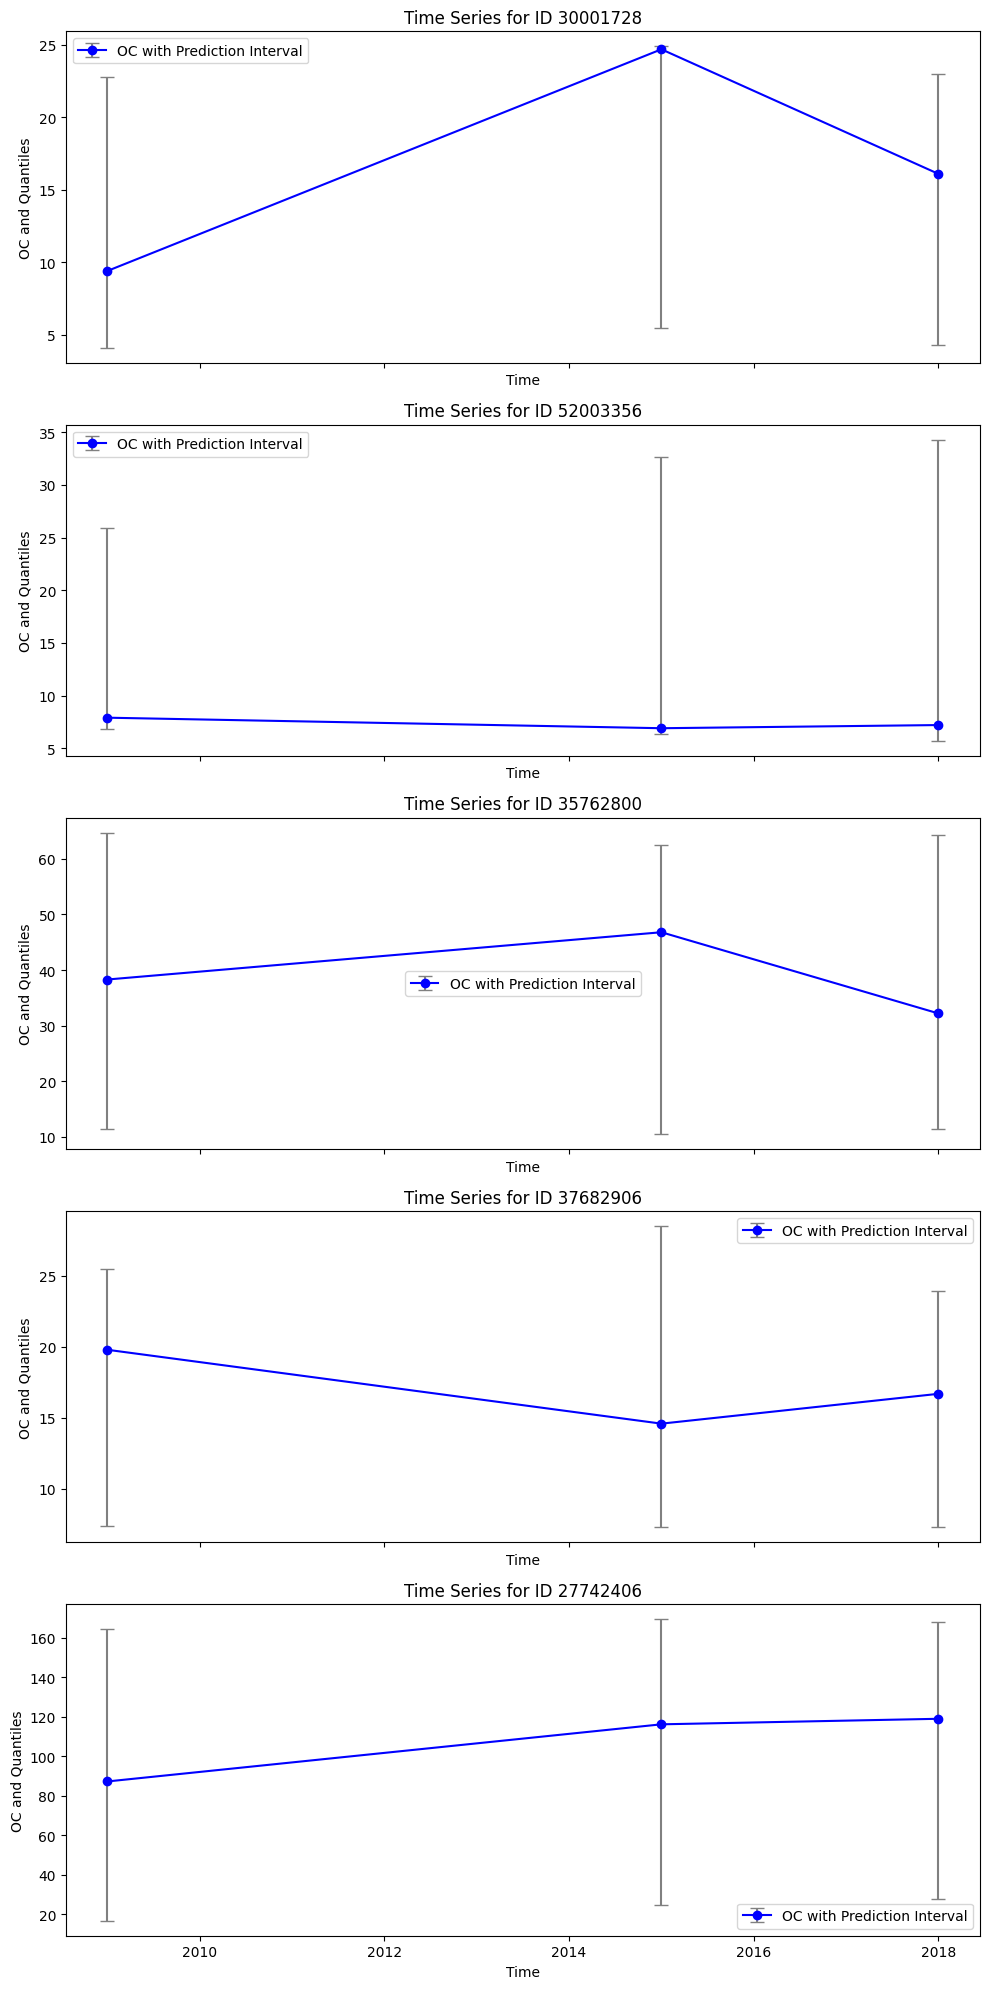

In [13]:
sample_ids = np.random.choice(data['id'].unique(), size=5, replace=False)
fig, axes = plt.subplots(nrows=len(sample_ids), ncols=1, figsize=(10, 20), sharex=True)

for i, sample_id in enumerate(sample_ids):
    sample_data = data[data['id'] == sample_id].sort_values('time')
    
    # Using error bars to represent quantiles instead of fill_between
    axes[i].errorbar(sample_data['time'], sample_data['oc'], 
                     yerr=[sample_data['oc'] - sample_data['oc_quantile.05'], sample_data['oc_quantile.95'] - sample_data['oc']], 
                     fmt='o', linestyle='-', color='blue', ecolor='gray', capsize=5, label='OC with Prediction Interval')
    
    axes[i].set_title(f'Time Series for ID {sample_id}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('OC and Quantiles')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [20]:
def check_non_overlapping_intervals(data):
    data = data.sort_values('time')
    for i in range(len(data) - 1):
        if not (data.iloc[i]['oc_quantile.95'] < data.iloc[i + 1]['oc_quantile.05'] or
                data.iloc[i]['oc_quantile.05'] > data.iloc[i + 1]['oc_quantile.95']):
            return False
    return True

non_overlapping_ids = []
for id, group in test[test['hzn_dep'] == 10].groupby('id'):
    if len(group['time'].unique()) > 1 and check_non_overlapping_intervals(group):
        non_overlapping_ids.append(id)


In [21]:
import matplotlib.pyplot as plt

for sample_id in non_overlapping_ids:
    sample_data = test[test['id'] == sample_id].sort_values('time')
    plt.figure(figsize=(10, 4))
    plt.fill_between(sample_data['time'], sample_data['oc_quantile.05'], sample_data['oc_quantile.95'], color='gray', alpha=0.5)
    plt.plot(sample_data['time'], sample_data['oc'], marker='o', linestyle='-', color='blue')
    plt.title(f'Time Series for ID {sample_id}')
    plt.xlabel('Time')
    plt.ylabel('OC and Quantiles')
    plt.show()

In [24]:
non_overlapping_ids

[]

In [18]:
test.loc[test['id']==48544672]

id        lat        lon    time    ref nuts0     oc  ph_h2o  \
4481  48544672  64.769362  21.186397  2018.0  LUCAS    SE  499.3     3.8   

      ph_cacl2  bulk_density  ...  lithology_EGDI_trachyte  \
4481       3.1           NaN  ...                        0   

      lithology_EGDI_trachytoid  \
4481                          0   

      lithology_EGDI_tuffBrecciaAgglomerateOrPyroclasticBreccia  \
4481                                                  0           

      lithology_EGDI_ultramaficIgneousRock  lithology_EGDI_wacke  \
4481                                     0                     1   

      lithology_EGDI_Unpopulated  hzn_dep  oc_log1p  oc_quantile.95  \
4481                           0     10.0  6.215208         496.325   

      oc_quantile.05  
4481            9.99  

[1 rows x 557 columns]

In [30]:
import pandas as pd

prop_list = ['oc', 'ph_h2o', 'ph_cacl2', 'bulk_density', 'caco3', 'CEC', 'EC', 'P', 'K', 'N']
higher_better = ['R2_val', 'CCC_val', 'R2_cv', 'CCC_cv']
lower_better = ['RMSE_val', 'RMSE_cv'] #, 'cv_time (s)', 'test_time (s)'
best = []

for prop in prop_list:
    df = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/results/{prop}/benchmark_metrics_{prop}.csv')
    df['property'] = prop

    # Ranking the metrics appropriately
    for col in higher_better:
        df[col + '_rank'] = df[col].rank(method='min', ascending=False)
        
    for col in lower_better:
        df[col + '_rank'] = df[col].rank(method='min', ascending=True)
        
    # Sum only the necessary rank columns
    rank_columns = [col + '_rank' for col in higher_better + lower_better]
    df['total_rank'] = df[rank_columns].sum(axis=1)
    df_sorted = df.sort_values(by='total_rank')
    best_model = df_sorted.iloc[0]

    # Drop rank columns from the best model row
    best_model = best_model.drop(rank_columns + ['total_rank'])

    best.append(best_model)

# Convert best list to DataFrame to view all best models from each property
best_df = pd.DataFrame(best)

# Reordering columns to put 'property' first
column_order = ['property'] + [col for col in best_df.columns if col != 'property']
best_df = best_df[column_order]

print(best_df)



       property         title    R2_val  RMSE_val   CCC_val     R2_cv  \
0            oc            rf  0.550675  0.611548  0.705930  0.624623   
0        ph_h2o            rf  0.762732  0.660015  0.858765  0.674683   
0      ph_cacl2            rf  0.765558  0.687311  0.860912  0.655177   
4  bulk_density  lgb_weighted  0.292882  0.414352  0.435651  0.445969   
3         caco3   rf_weighted  0.667276  1.271670  0.786871  0.601751   
2           CEC           lgb  0.415466  0.540335  0.569839  0.422562   
3            EC   rf_weighted  0.369354  0.590715  0.509706  0.507062   
3             P   rf_weighted  0.296192  0.957347  0.457729  0.346011   
3             K   rf_weighted  0.419998  0.683437  0.572280  0.398401   
0             N            rf  0.616684  0.406434  0.754714  0.757725   

    RMSE_cv    CCC_cv  cv_time (s)  test_time (s)  Unnamed: 0  
0  0.676012  0.763311   614.944233     736.984381         NaN  
0  0.719266  0.796075   290.555274     328.525917         NaN  
0  0

In [32]:
best_df.drop(columns='Unnamed: 0')
best_df

property         title    R2_val  RMSE_val   CCC_val     R2_cv  \
0            oc            rf  0.550675  0.611548  0.705930  0.624623   
0        ph_h2o            rf  0.762732  0.660015  0.858765  0.674683   
0      ph_cacl2            rf  0.765558  0.687311  0.860912  0.655177   
4  bulk_density  lgb_weighted  0.292882  0.414352  0.435651  0.445969   
3         caco3   rf_weighted  0.667276  1.271670  0.786871  0.601751   
2           CEC           lgb  0.415466  0.540335  0.569839  0.422562   
3            EC   rf_weighted  0.369354  0.590715  0.509706  0.507062   
3             P   rf_weighted  0.296192  0.957347  0.457729  0.346011   
3             K   rf_weighted  0.419998  0.683437  0.572280  0.398401   
0             N            rf  0.616684  0.406434  0.754714  0.757725   

    RMSE_cv    CCC_cv  cv_time (s)  test_time (s)  Unnamed: 0  
0  0.676012  0.763311   614.944233     736.984381         NaN  
0  0.719266  0.796075   290.555274     328.525917         NaN  
0  0.776174  0.783522   258.228914     301.483572         0.0  
4  0.308375  0.618167     8.882182       0.524796         4.0  
3  1.315935  0.734305   684.725839     678.963798         NaN  
2  0.574404  0.580318     7.355814       0.666214         NaN  
3  0.596562  0.658933   485.496367     564.575928         NaN  
3  0.896511  0.496441   539.523615     666.693592         NaN  
3  0.692988  0.550719   311.691685     362.179350         NaN  
0  0.424957  0.857447   307.250937     367.733524         NaN

In [ ]:


# Rank the models in each metric
